In [61]:
# First let's load the file with all the flights in the US for the 12 months up to September 2024. This is available at the DoT website as DB28IS. 
# Each month teh last 12 months of flights are available to download. The data is on a rolling basis, the latest being September 2024.

import pandas as pd

# Specify the file path
file_path = "./Flight_data_Sep2024_DoT.csv"

# Load the file into a Pandas DataFrame
flight_data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(flight_data.head())

# Display the column names
print("Column names:", flight_data.columns.tolist())


   Year  Month Origin_Airport  Origin_Airport_UC  Origin_Airport_WAC  \
0  2024      9            01A              30001                   1   
1  2024      8            01A              30001                   1   
2  2024      7            05A              30005                   1   
3  2024      8            06A              30006                   1   
4  2024      8            06A              30006                   1   

  Origin_Airport_City Destination_Airport  Destination_Airport_UC  \
0    Afognak Lake, AK                 A43                   30056   
1    Afognak Lake, AK                 A43                   30056   
2    Little Squaw, AK                 FAI                   31517   
3        Kizhuyak, AK                 A43                   30056   
4        Kizhuyak, AK                 A43                   30056   

   Destination_Airport_WAC Destination_Airport_City  ... Departures_Performed  \
0                        1        Kodiak Island, AK  ...               

In [62]:
# We want to filter only flights with F on the Service_Class (Scheduled flights) column that have at least 12 scheduled flights on the year. 
# Otherwise we get flights between airports that are not really relevant to study the resilience of the system.  

# Number of rows before filtering
rows_before = len(flight_data)

# Filter for scheduled flight data with Service_Class = 'F' and Departures_Planned > 12
scheduled_flight_data = flight_data[
    (flight_data['Service_Class'] == 'F') & (flight_data['Departures_Planned'] > 12)
]

# Number of rows after filtering
rows_after = len(scheduled_flight_data)

# Print the results
print(f"Number of rows before filtering: {rows_before}")
print(f"Number of rows after filtering: {rows_after}")


Number of rows before filtering: 433430
Number of rows after filtering: 159581


In [63]:
# Need to get the data in a format that will allow us to build a graph.
# Group the data by origin and destination airport codes 
grouped_data = scheduled_flight_data.groupby(
    ['Origin_Airport', 'Destination_Airport']
).agg(
    Total_Available_seats=('Available_seats', 'sum'),
    Total_Passengers_transported=('Passengers_transported', 'sum')
).reset_index()

# Save the grouped dataset to a new DataFrame
flight_data = grouped_data[['Origin_Airport', 'Destination_Airport', 
                                 'Total_Available_seats', 'Total_Passengers_transported']]

# Display the first few rows of the new dataset
print(flight_data.head())

# Optionally save the new dataset to a CSV file
flight_data.to_csv("./Consolidated_Flight_Data.csv", index=False)

print(f"Total Available Seats: {flight_data['Total_Available_seats'].sum()}")
print(f"Total Passengers Transported: {flight_data['Total_Passengers_transported'].sum()}")
print(f"Load factor: {flight_data['Total_Passengers_transported'].sum()/flight_data['Total_Available_seats'].sum()}")


  Origin_Airport Destination_Airport  Total_Available_seats  \
0            2WA                 2WA                   1595   
1            2WA                 FBS                    920   
2            2WA                 KEH                    560   
3            7AK                 DUT                   3171   
4            ABE                 ATL                  72255   

   Total_Passengers_transported  
0                           974  
1                           334  
2                            65  
3                           780  
4                         63643  
Total Available Seats: 945301832
Total Passengers Transported: 772665261
Load factor: 0.817374128393734


In [64]:
# Let's now group the data for the year. The nodes are the airpots and the weights are the available seats and the transported passengers. 

import pandas as pd
import networkx as nx
import pickle

# Load the dataset
file_path = './Consolidated_Flight_Data.csv'
flight_data = pd.read_csv(file_path)

# Initialize a directed graph
G = nx.DiGraph()

# Add edges with weights to the graph
for _, row in flight_data.iterrows():
    origin = row['Origin_Airport']
    destination = row['Destination_Airport']
    available_seats = row['Total_Available_seats']
    passengers = row['Total_Passengers_transported']
    
    # Add the edge with weights
    G.add_edge(
        origin, 
        destination, 
        available_seats=available_seats, 
        passengers=passengers
    )

# Save the graph using pickle
output_file = "./flight_graph.pkl"
with open(output_file, 'wb') as f:
    pickle.dump(G, f)
print(f"Graph saved to {output_file}")

# Reload the graph later if needed
# with open(output_file, 'rb') as f:
#     G = pickle.load(f)


Graph saved to ./flight_graph.pkl


In [65]:
# Let's check the structure of the graph and subgraphs. 

import networkx as nx
from collections import Counter

# Calculate the weakly connected components (subgraphs)
subgraph_sizes = [len(component) for component in nx.weakly_connected_components(G)]

# Count the subgraphs by their size
subgraph_size_counts = Counter(subgraph_sizes)

# Sort the counts by the number of nodes
sorted_subgraph_sizes = sorted(subgraph_size_counts.items(), key=lambda x: x[0])

# Display the results
print("Subgraph Sizes (Ordered by Number of Nodes):")
for size, count in sorted_subgraph_sizes:
    print(f"{count} subgraphs with {size} nodes")


Subgraph Sizes (Ordered by Number of Nodes):
6 subgraphs with 2 nodes
1 subgraphs with 3 nodes
2 subgraphs with 5 nodes
1 subgraphs with 9 nodes
1 subgraphs with 551 nodes


In [66]:
# The current graph has very small subgraphs. We checked the nodes and these are very small airports with ad-hoc flights apparently. Let's remove these subgraphs. 

In [67]:
# Clean up subgraphs that are not relevant. 

import networkx as nx
import pickle

# Load the graph from a file
file_path = 'flight_graph.pkl'  # Update this with the path to your graph file
with open(file_path, 'rb') as f:
    G = pickle.load(f)

# Identify subgraphs with fewer than 10 nodes and remove them
subgraphs_to_remove = [component for component in nx.weakly_connected_components(G) if len(component) < 10]
nodes_to_remove = set(node for component in subgraphs_to_remove for node in component)
G_clean = G.copy()
G_clean.remove_nodes_from(nodes_to_remove)

# Save the cleaned graph to a new file
cleaned_file_path = 'flight_graph_clean.pkl'  # Update this with the desired output file name
with open(cleaned_file_path, 'wb') as f:
    pickle.dump(G_clean, f)

G = G_clean

print(f"Cleaned graph saved to {cleaned_file_path}")

# G is now a cleaned graph with only one subgraph. 


Cleaned graph saved to flight_graph_clean.pkl


In [68]:
# Let's check the structure of the graph and subgraphs. 

import networkx as nx
from collections import Counter

# Calculate the weakly connected components (subgraphs)
subgraph_sizes = [len(component) for component in nx.weakly_connected_components(G)]

# Count the subgraphs by their size
subgraph_size_counts = Counter(subgraph_sizes)

# Sort the counts by the number of nodes
sorted_subgraph_sizes = sorted(subgraph_size_counts.items(), key=lambda x: x[0])

# Display the results
print("Subgraph Sizes (Ordered by Number of Nodes):")
for size, count in sorted_subgraph_sizes:
    print(f"{count} subgraphs with {size} nodes")

Subgraph Sizes (Ordered by Number of Nodes):
1 subgraphs with 551 nodes


In [69]:
# Let's check how the graph is structured now and that is clean.

import networkx as nx

# Check if the graph is strongly connected
is_strongly_connected = nx.is_strongly_connected(G)

# Check if the graph is weakly connected
is_weakly_connected = nx.is_weakly_connected(G)

# Count the number of strongly connected components (subgraphs)
num_strongly_connected_components = nx.number_strongly_connected_components(G)

# Count the number of weakly connected components (subgraphs)
num_weakly_connected_components = nx.number_weakly_connected_components(G)

# Print the results
print("Graph Connectivity and Subgraph Analysis:")
print(f"Is Strongly Connected: {'Yes' if is_strongly_connected else 'No'}")
print(f"Is Weakly Connected: {'Yes' if is_weakly_connected else 'No'}")
print(f"Number of Strongly Connected Components: {num_strongly_connected_components}")
print(f"Number of Weakly Connected Components: {num_weakly_connected_components}")



Graph Connectivity and Subgraph Analysis:
Is Strongly Connected: No
Is Weakly Connected: Yes
Number of Strongly Connected Components: 11
Number of Weakly Connected Components: 1


In [70]:
# Let's check the sizes of the SCCs

import networkx as nx

# Check if the graph is strongly connected
is_strongly_connected = nx.is_strongly_connected(G)

# Check if the graph is weakly connected
is_weakly_connected = nx.is_weakly_connected(G)

# Count the number of strongly connected components (subgraphs)
num_strongly_connected_components = nx.number_strongly_connected_components(G)

# Count the number of weakly connected components (subgraphs)
num_weakly_connected_components = nx.number_weakly_connected_components(G)

# Print the connectivity results
print("Graph Connectivity and Subgraph Analysis:")
print(f"Is Strongly Connected: {'Yes' if is_strongly_connected else 'No'}")
print(f"Is Weakly Connected: {'Yes' if is_weakly_connected else 'No'}")
print(f"Number of Strongly Connected Components: {num_strongly_connected_components}")
print(f"Number of Weakly Connected Components: {num_weakly_connected_components}")

# Get the strongly connected components
strongly_connected_components = list(nx.strongly_connected_components(G))

# Count the number of nodes in each SCC
scc_sizes = [len(component) for component in strongly_connected_components]

# Print the sizes of each SCC
print("\nNumber of Nodes in Each Strongly Connected Component:")
for i, size in enumerate(sorted(scc_sizes, reverse=True), start=1):
    print(f"Component {i}: {size} nodes")


Graph Connectivity and Subgraph Analysis:
Is Strongly Connected: No
Is Weakly Connected: Yes
Number of Strongly Connected Components: 11
Number of Weakly Connected Components: 1

Number of Nodes in Each Strongly Connected Component:
Component 1: 541 nodes
Component 2: 1 nodes
Component 3: 1 nodes
Component 4: 1 nodes
Component 5: 1 nodes
Component 6: 1 nodes
Component 7: 1 nodes
Component 8: 1 nodes
Component 9: 1 nodes
Component 10: 1 nodes
Component 11: 1 nodes


In [71]:
import pickle

# Get the strongly connected components (SCCs)
strongly_connected_components = list(nx.strongly_connected_components(G))

# Identify SCCs with fewer than 10 nodes
small_sccs = [component for component in strongly_connected_components if len(component) < 10]

# Flatten the list of small SCC nodes into a single set
nodes_to_remove = set(node for component in small_sccs for node in component)

# Create a copy of the graph and remove the nodes
G_clean = G.copy()
G_clean.remove_nodes_from(nodes_to_remove)

# Save the cleaned graph to a file
output_file_path = 'flight_graph_clean.pkl'
with open(output_file_path, 'wb') as f:
    pickle.dump(G_clean, f)

G = G_clean

print(f"Cleaned graph saved to {output_file_path}")

# Check if the graph is strongly connected
is_strongly_connected = nx.is_strongly_connected(G)

# Check if the graph is weakly connected
is_weakly_connected = nx.is_weakly_connected(G)

# Count the number of strongly connected components (subgraphs)
num_strongly_connected_components = nx.number_strongly_connected_components(G)

# Count the number of weakly connected components (subgraphs)
num_weakly_connected_components = nx.number_weakly_connected_components(G)

# Print the results
print("Graph Connectivity and Subgraph Analysis:")
print(f"Is Strongly Connected: {'Yes' if is_strongly_connected else 'No'}")
print(f"Is Weakly Connected: {'Yes' if is_weakly_connected else 'No'}")
print(f"Number of Strongly Connected Components: {num_strongly_connected_components}")
print(f"Number of Weakly Connected Components: {num_weakly_connected_components}")




Cleaned graph saved to flight_graph_clean.pkl
Graph Connectivity and Subgraph Analysis:
Is Strongly Connected: Yes
Is Weakly Connected: Yes
Number of Strongly Connected Components: 1
Number of Weakly Connected Components: 1


Number of nodes (airports): 541
Number of edges (flights): 6535

Top 5 airports by in-degree (most incoming destinations):
DFW: 188 destinations
DEN: 182 destinations
ORD: 167 destinations
ATL: 157 destinations
CLT: 138 destinations

Top 5 airports by out-degree (most outgoing destinations):
DFW: 188 destinations
DEN: 181 destinations
ORD: 168 destinations
ATL: 157 destinations
CLT: 139 destinations


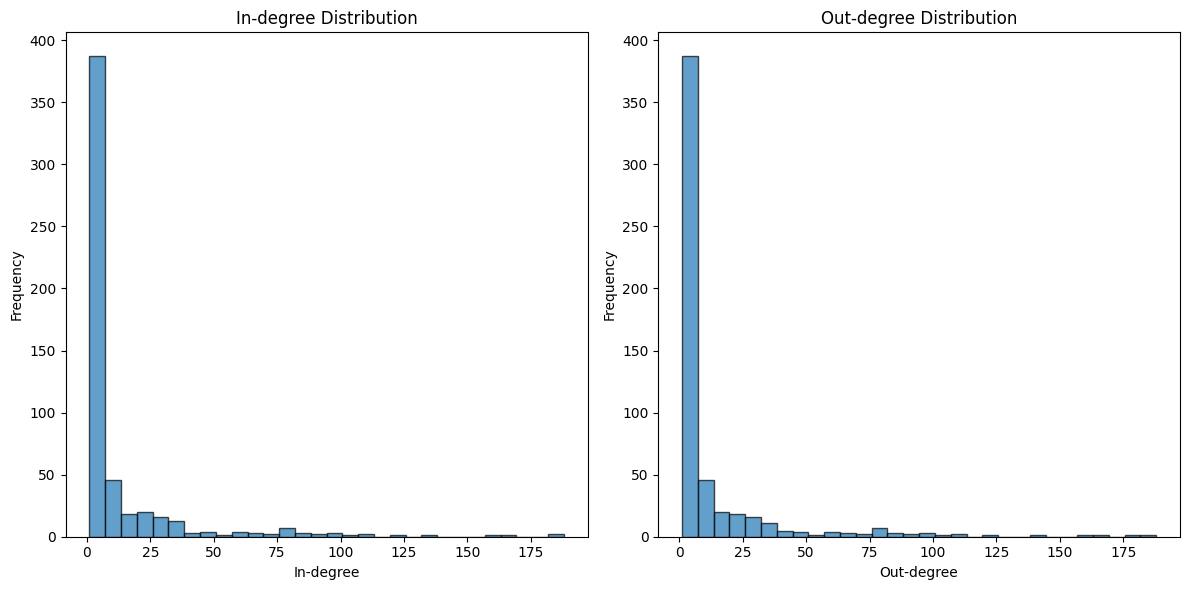

In [72]:
# Let's do a basic analysis of the graph.

import networkx as nx
import matplotlib.pyplot as plt


output_file = "./flight_graph_clean.pkl"

with open(output_file, 'rb') as f:
     G = pickle.load(f)

# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes (airports): {num_nodes}")
print(f"Number of edges (flights): {num_edges}")

# Compute in-degree and out-degree distributions
in_degrees = dict(G.in_degree())  # Number of incoming edges for each node
out_degrees = dict(G.out_degree())  # Number of outgoing edges for each node

# Top 5 airports with the highest in-degree
top_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by in-degree (most incoming destinations):")
for airport, degree in top_in_degree:
    print(f"{airport}: {degree} destinations")

# Top 5 airports with the highest out-degree
top_out_degree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by out-degree (most outgoing destinations):")
for airport, degree in top_out_degree:
    print(f"{airport}: {degree} destinations")

# Plot degree distributions
plt.figure(figsize=(12, 6))

# In-degree distribution
plt.subplot(1, 2, 1)
plt.hist(in_degrees.values(), bins=30, edgecolor='black', alpha=0.7)
plt.title("In-degree Distribution")
plt.xlabel("In-degree")
plt.ylabel("Frequency")

# Out-degree distribution
plt.subplot(1, 2, 2)
plt.hist(out_degrees.values(), bins=30, edgecolor='black', alpha=0.7)
plt.title("Out-degree Distribution")
plt.xlabel("Out-degree")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [73]:
# Calculate centrality measures and get the top airport for each centrality measure. 

import networkx as nx

# 1. Degree Centrality
degree_centrality = nx.degree_centrality(G)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by Degree Centrality (most connections):")
for airport, centrality in top_degree_centrality:
    print(f"{airport}: {centrality:.4f}")

# 2. Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by Betweenness Centrality (critical for connectivity):")
for airport, centrality in top_betweenness_centrality:
    print(f"{airport}: {centrality:.4f}")

# 3. Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by Closeness Centrality (reach others quickly):")
for airport, centrality in top_closeness_centrality:
    print(f"{airport}: {centrality:.4f}")

# 4. Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
top_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 airports by Eigenvector Centrality (connected to important airports):")
for airport, centrality in top_eigenvector_centrality:
    print(f"{airport}: {centrality:.4f}")



Top 5 airports by Degree Centrality (most connections):
DFW: 0.6963
DEN: 0.6722
ORD: 0.6204
ATL: 0.5815
CLT: 0.5130

Top 5 airports by Betweenness Centrality (critical for connectivity):
ANC: 0.2924
DEN: 0.1624
DFW: 0.1425
BET: 0.1254
ORD: 0.1242

Top 5 airports by Closeness Centrality (reach others quickly):
DEN: 0.5325
DFW: 0.5243
ORD: 0.5238
ATL: 0.5061
MSP: 0.5047

Top 5 airports by Eigenvector Centrality (connected to important airports):
DFW: 0.1890
ATL: 0.1863
DEN: 0.1861
ORD: 0.1804
CLT: 0.1657


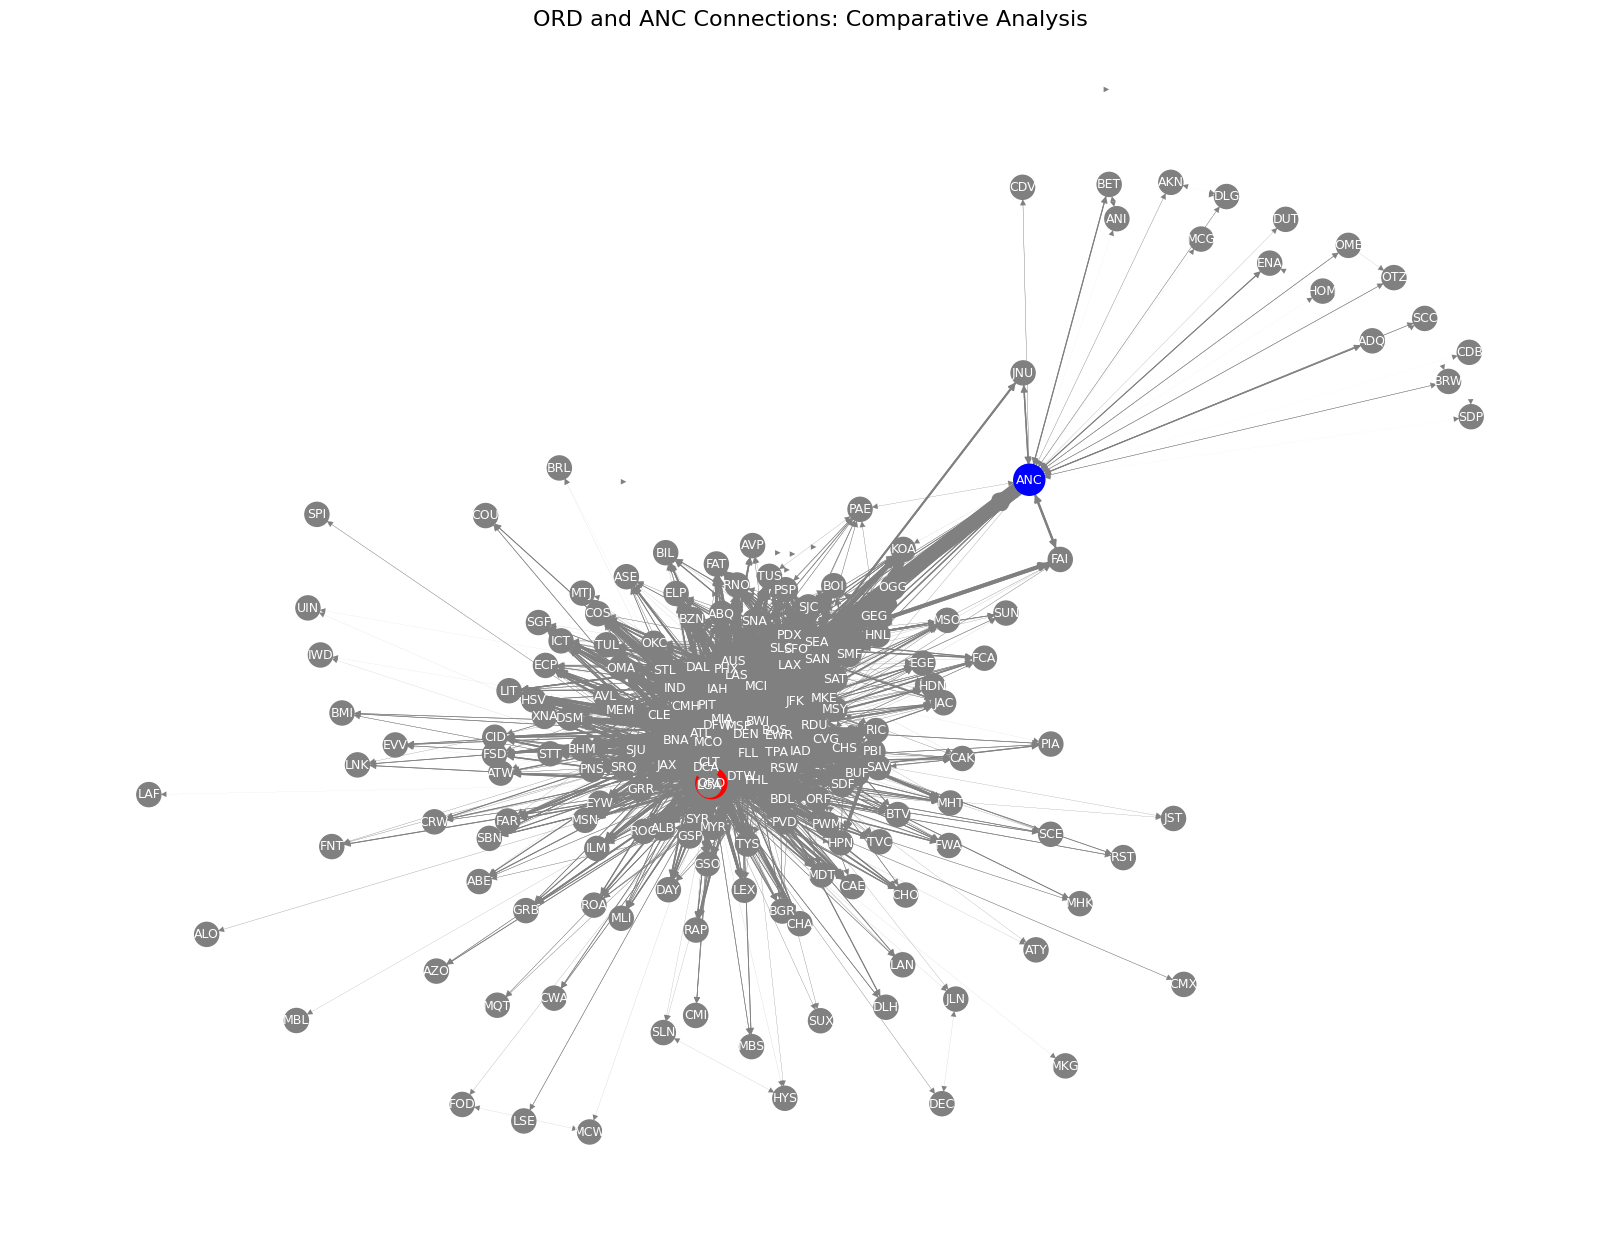

Comparison Between ANC (Anchorage) and ORD (Chicago O'Hare):

ANC (Anchorage):
  In-Degree: 37
  Out-Degree: 37
  Total Passengers (Outgoing): 2287880
  Total Available Seats (Outgoing): 3011163
  Betweenness Centrality: 0.2924344527420958

ORD (Chicago O'Hare):
  In-Degree: 167
  Out-Degree: 168
  Total Passengers (Outgoing): 28193693
  Total Available Seats (Outgoing): 33677750
  Betweenness Centrality: 0.12422406142330375


In [74]:
# ANC - Anchorage in Alaska shows a very high Betweeness centrality number and it is an outliar if we consider other centrality measures. 
# Let's check the results against ORD (Chicago)

import networkx as nx
import matplotlib.pyplot as plt

# Function to analyze a specific airport
def analyze_airport(graph, airport):
    # Degree Analysis
    in_degree = graph.in_degree(airport)
    out_degree = graph.out_degree(airport)
    
    # Total passengers and available seats
    edges = graph.edges(airport, data=True)  # Outgoing flights
    total_passengers = sum(edge_data['passengers'] for _, _, edge_data in edges)
    total_available_seats = sum(edge_data['available_seats'] for _, _, edge_data in edges)
    
    # Betweenness Centrality
    betweenness = nx.betweenness_centrality(graph).get(airport, 0)
    
    return {
        "In-Degree": in_degree,
        "Out-Degree": out_degree,
        "Total Passengers (Outgoing)": total_passengers,
        "Total Available Seats (Outgoing)": total_available_seats,
        "Betweenness Centrality": betweenness,
    }

# Analyze ANC and ORD
anc_metrics = analyze_airport(G, 'ANC')
ord_metrics = analyze_airport(G, 'ORD')

# Comparison
comparison = {
    "ANC (Anchorage)": anc_metrics,
    "ORD (Chicago O'Hare)": ord_metrics,
}

# Visualization: Subgraph for ANC and ORD
ord_anc_nodes = ['ORD', 'ANC'] + list(G.successors('ORD')) + list(G.predecessors('ORD')) \
    + list(G.successors('ANC')) + list(G.predecessors('ANC'))
ord_anc_subgraph = G.subgraph(ord_anc_nodes)

# Node sizes based on importance
node_sizes = [500 if node in ['ORD', 'ANC'] else 300 for node in ord_anc_subgraph.nodes()]

# Edge widths based on passenger volume
edge_widths = [
    edge_data['passengers'] / 1e5 for _, _, edge_data in ord_anc_subgraph.edges(data=True)
]

# Node colors
node_colors = ['red' if node == 'ORD' else 'blue' if node == 'ANC' else 'gray' for node in ord_anc_subgraph.nodes()]

# Plot the subgraph for ORD and ANC
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(ord_anc_subgraph, seed=42)
nx.draw(
    ord_anc_subgraph,
    pos,
    with_labels=True,
    node_size=node_sizes,
    font_size=9,
    font_color="white",
    edge_color="gray",
    width=edge_widths,
    node_color=node_colors,
)

# Add title
plt.title("ORD and ANC Connections: Comparative Analysis", fontsize=16)
plt.show()

# Print comparison
print("Comparison Between ANC (Anchorage) and ORD (Chicago O'Hare):")
for airport, metrics in comparison.items():
    print(f"\n{airport}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")


In [75]:
# Rechecking how many subgraphs to check if this is a good representation of the flight network in the US. 

import networkx as nx
from collections import Counter

# Calculate the weakly connected components (subgraphs) for the directed graph
subgraph_sizes = [len(component) for component in nx.weakly_connected_components(G)]

# Count the subgraphs by their size
subgraph_size_counts = Counter(subgraph_sizes)

# Sort the counts by the number of nodes
sorted_subgraph_sizes = sorted(subgraph_size_counts.items(), key=lambda x: x[0])

# Display the results
print("Subgraph Sizes (Ordered by Number of Nodes):")
for size, count in sorted_subgraph_sizes:
    print(f"{count} subgraphs with {size} nodes")


Subgraph Sizes (Ordered by Number of Nodes):
1 subgraphs with 541 nodes


In [76]:
# Checking if it is strongly connected.

import networkx as nx

# Check if the graph is strongly connected
is_strongly_connected = nx.is_strongly_connected(G)

# Check if the graph is weakly connected
is_weakly_connected = nx.is_weakly_connected(G)

# Output the results
print(f"Is the graph strongly connected? {'Yes' if is_strongly_connected else 'No'}")
print(f"Is the graph weakly connected? {'Yes' if is_weakly_connected else 'No'}")


Is the graph strongly connected? Yes
Is the graph weakly connected? Yes


In [77]:
# Find if there are any small SCCs.

import networkx as nx

# Get the largest strongly connected component
largest_scc = max(nx.strongly_connected_components(G), key=len)

# Find nodes that are not in the largest SCC
unconnected_nodes = set(G.nodes()) - largest_scc

# Display the results
print(f"Number of unconnected nodes: {len(unconnected_nodes)}")
print("Unconnected nodes:", unconnected_nodes)


Number of unconnected nodes: 0
Unconnected nodes: set()


In [78]:
import networkx as nx
import pickle

# Print the number of nodes and edges before filtering
print(f"Before Filtering: Nodes = {G_clean.number_of_nodes()}, Edges = {G_clean.number_of_edges()}")

# Identify nodes with less than 500 total passengers
nodes_to_remove = []
for node in G_clean.nodes():
    total_passengers = sum(
        data.get('passengers', 0)
        for _, _, data in G_clean.in_edges(node, data=True)
    ) + sum(
        data.get('passengers', 0)
        for _, _, data in G_clean.out_edges(node, data=True)
    )
    if total_passengers < 500:
        nodes_to_remove.append(node)

# Remove these nodes from the graph
G_filtered = G_clean.copy()
G_filtered.remove_nodes_from(nodes_to_remove)

# Print the number of nodes and edges after filtering
print(f"After Filtering: Nodes = {G_filtered.number_of_nodes()}, Edges = {G_filtered.number_of_edges()}")

# Save the filtered graph to a new file
filtered_file_path = './flight_graph_filtered.pkl'
with open(filtered_file_path, 'wb') as f:
    pickle.dump(G_filtered, f)

print(f"Filtered graph saved to {filtered_file_path}")

# Update the reference to the filtered graph
G = G_filtered


Before Filtering: Nodes = 541, Edges = 6535
After Filtering: Nodes = 526, Edges = 6505
Filtered graph saved to ./flight_graph_filtered.pkl


In [79]:
# We have now a good representation of the flight network. 
# Let's see what happens if we remove nodes based on centrality measures. 

import networkx as nx
import random
from concurrent.futures import ThreadPoolExecutor

# Function to compute connectivity details
def graph_connectivity_info(graph):
    is_connected = nx.is_strongly_connected(graph)
    num_subgraphs = nx.number_strongly_connected_components(graph)
    return is_connected, num_subgraphs

# Function to remove nodes based on strategy
def remove_nodes(graph, strategy, num_nodes):
    graph_copy = graph.copy()
    nodes = list(graph_copy.nodes())
    if strategy == "random":
        nodes_to_remove = random.sample(nodes, num_nodes)
    else:
        if strategy == "degree":
            centrality = nx.degree_centrality(graph_copy)
        elif strategy == "betweenness":
            centrality = nx.betweenness_centrality(graph_copy)
        elif strategy == "closeness":
            centrality = nx.closeness_centrality(graph_copy)
        nodes_to_remove = [
            node for node, _ in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:num_nodes]
        ]
    graph_copy.remove_nodes_from(nodes_to_remove)
    return graph_copy

# Task for concurrent execution
def analyze_removal(graph, strategy, num_nodes):
    modified_graph = remove_nodes(graph, strategy, num_nodes)
    is_connected, num_subgraphs = graph_connectivity_info(modified_graph)
    return strategy, num_nodes, is_connected, num_subgraphs

# Parameters
strategies = ["random", "degree", "betweenness", "closeness"]
node_removals = [1, 2, 3, 5, 10, 20, 30, 50]

# Execute using ThreadPoolExecutor
results = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(analyze_removal, G, strategy, num)
        for strategy in strategies
        for num in node_removals
    ]
    for future in futures:
        results.append(future.result())

# Display results
for strategy, num_nodes, is_connected, num_subgraphs in results:
    print(f"Strategy: {strategy}, Nodes Removed: {num_nodes}, "
          f"Connected: {is_connected}, Subgraphs: {num_subgraphs}")


Strategy: random, Nodes Removed: 1, Connected: True, Subgraphs: 1
Strategy: random, Nodes Removed: 2, Connected: True, Subgraphs: 1
Strategy: random, Nodes Removed: 3, Connected: False, Subgraphs: 5
Strategy: random, Nodes Removed: 5, Connected: True, Subgraphs: 1
Strategy: random, Nodes Removed: 10, Connected: False, Subgraphs: 2
Strategy: random, Nodes Removed: 20, Connected: False, Subgraphs: 2
Strategy: random, Nodes Removed: 30, Connected: False, Subgraphs: 3
Strategy: random, Nodes Removed: 50, Connected: False, Subgraphs: 12
Strategy: degree, Nodes Removed: 1, Connected: False, Subgraphs: 18
Strategy: degree, Nodes Removed: 2, Connected: False, Subgraphs: 39
Strategy: degree, Nodes Removed: 3, Connected: False, Subgraphs: 53
Strategy: degree, Nodes Removed: 5, Connected: False, Subgraphs: 74
Strategy: degree, Nodes Removed: 10, Connected: False, Subgraphs: 111
Strategy: degree, Nodes Removed: 20, Connected: False, Subgraphs: 155
Strategy: degree, Nodes Removed: 30, Connected: Fa

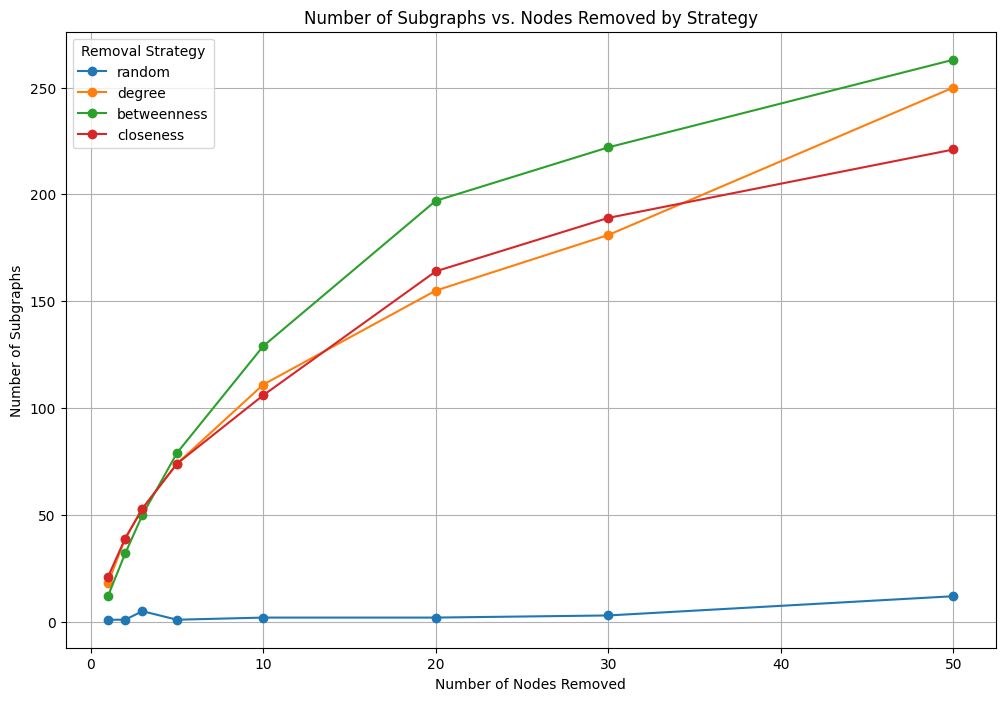

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `results` is the list of tuples with analysis data
# Convert results into a DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=["Strategy", "Nodes Removed", "Connected", "Subgraphs"])

# Plot the number of subgraphs for each strategy
plt.figure(figsize=(12, 8))

for strategy in results_df["Strategy"].unique():
    strategy_data = results_df[results_df["Strategy"] == strategy]
    plt.plot(
        strategy_data["Nodes Removed"],
        strategy_data["Subgraphs"],
        label=strategy,
        marker='o'
    )

plt.title("Number of Subgraphs vs. Nodes Removed by Strategy")
plt.xlabel("Number of Nodes Removed")
plt.ylabel("Number of Subgraphs")
plt.legend(title="Removal Strategy")
plt.grid(True)
plt.show()


In [81]:
import networkx as nx
import random
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

# Function to compute connectivity details and shortest paths
def graph_connectivity_info(graph):
    is_connected = nx.is_strongly_connected(graph)
    num_subgraphs = nx.number_strongly_connected_components(graph)

    # Calculate shortest path details
    shortest_shortest_path = None
    longest_shortest_path = None
    if is_connected:
        shortest_path_lengths = dict(nx.shortest_path_length(graph))
        all_shortest_paths = [
            length
            for target_lengths in shortest_path_lengths.values()
            for length in target_lengths.values()
        ]
        shortest_shortest_path = min(all_shortest_paths)
        longest_shortest_path = max(all_shortest_paths)

    return is_connected, num_subgraphs, shortest_shortest_path, longest_shortest_path

# Function to compute centrality measures
def compute_centrality_measures(graph):
    with ThreadPoolExecutor() as executor:
        degree_future = executor.submit(nx.degree_centrality, graph)
        betweenness_future = executor.submit(nx.betweenness_centrality, graph)
        closeness_future = executor.submit(nx.closeness_centrality, graph)

        # Gather results
        degree_centrality = degree_future.result()
        betweenness_centrality = betweenness_future.result()
        closeness_centrality = closeness_future.result()

    return {
        "Degree Centrality": degree_centrality,
        "Betweenness Centrality": betweenness_centrality,
        "Closeness Centrality": closeness_centrality,
    }

# Function to remove nodes based on strategy
def remove_nodes(graph, strategy, num_nodes):
    graph_copy = graph.copy()
    nodes = list(graph_copy.nodes())
    if strategy == "random":
        nodes_to_remove = random.sample(nodes, num_nodes)
    else:
        if strategy == "degree":
            centrality = nx.degree_centrality(graph_copy)
        elif strategy == "betweenness":
            centrality = nx.betweenness_centrality(graph_copy)
        elif strategy == "closeness":
            centrality = nx.closeness_centrality(graph_copy)
        nodes_to_remove = [
            node for node, _ in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:num_nodes]
        ]
    graph_copy.remove_nodes_from(nodes_to_remove)
    return graph_copy

# Task for concurrent execution
def analyze_removal(graph, strategy, num_nodes):
    modified_graph = remove_nodes(graph, strategy, num_nodes)
    is_connected, num_subgraphs, shortest_shortest_path, longest_shortest_path = graph_connectivity_info(modified_graph)
    centrality_measures = compute_centrality_measures(modified_graph)

    return {
        "Strategy": strategy,
        "Nodes Removed": num_nodes,
        "Connected": is_connected,
        "Subgraphs": num_subgraphs,
        "Shortest Shortest Path": shortest_shortest_path,
        "Longest Shortest Path": longest_shortest_path,
        "Centrality Measures": centrality_measures,
    }

# Parameters
strategies = ["random", "degree", "betweenness", "closeness"]
node_removals = [1, 2, 3, 5, 10, 20, 30, 50]

# Execute using ThreadPoolExecutor
results = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(analyze_removal, G, strategy, num)
        for strategy in strategies
        for num in node_removals
    ]
    for future in futures:
        results.append(future.result())

# Convert results to a DataFrame
results_df = pd.DataFrame([
    {
        "Strategy": result["Strategy"],
        "Nodes Removed": result["Nodes Removed"],
        "Connected": result["Connected"],
        "Subgraphs": result["Subgraphs"],
        "Shortest Shortest Path": result["Shortest Shortest Path"],
        "Longest Shortest Path": result["Longest Shortest Path"],
    }
    for result in results
])

# Save the results
results_df.to_csv("graph_analysis_results.csv", index=False)

# Print the centrality measures for the first result as an example
example_result = results[0]
print(f"Example Centrality Measures for {example_result['Strategy']} with {example_result['Nodes Removed']} nodes removed:")
for measure, values in example_result["Centrality Measures"].items():
    print(f"{measure}: {dict(values)}")  # Display results


Example Centrality Measures for random with 1 nodes removed:
Degree Centrality: {'7AK': 0.003816793893129771, 'DUT': 0.007633587786259542, 'ABE': 0.030534351145038167, 'ATL': 0.5954198473282443, 'BNA': 0.30916030534351147, 'CLT': 0.5248091603053435, 'MYR': 0.1297709923664122, 'ORD': 0.6354961832061068, 'PGD': 0.12213740458015267, 'PIE': 0.1049618320610687, 'SFB': 0.10305343511450381, 'ABI': 0.003816793893129771, 'DFW': 0.7137404580152672, 'ABQ': 0.10687022900763359, 'AUS': 0.24045801526717556, 'BUR': 0.12595419847328243, 'BWI': 0.25572519083969464, 'CNM': 0.011450381679389313, 'DAL': 0.23282442748091603, 'DEN': 0.6889312977099237, 'HOU': 0.21564885496183206, 'IAH': 0.41221374045801523, 'JFK': 0.27099236641221375, 'LAS': 0.3912213740458015, 'LAX': 0.3568702290076336, 'LGB': 0.07633587786259542, 'LRU': 0.003816793893129771, 'MCI': 0.17175572519083968, 'MCO': 0.33969465648854963, 'MDW': 0.2862595419847328, 'MSP': 0.46564885496183206, 'OAK': 0.1412213740458015, 'PDX': 0.2213740458015267, '

In [82]:
import networkx as nx
import random
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

# Function to compute connectivity details and shortest paths
def graph_connectivity_info(graph):
    is_connected = nx.is_strongly_connected(graph)
    num_subgraphs = nx.number_strongly_connected_components(graph)

    # Calculate shortest path details
    shortest_shortest_path = None
    longest_shortest_path = None
    if is_connected:
        shortest_path_lengths = dict(nx.shortest_path_length(graph))
        all_shortest_paths = [
            length
            for target_lengths in shortest_path_lengths.values()
            for length in target_lengths.values()
        ]
        shortest_shortest_path = min(all_shortest_paths)
        longest_shortest_path = max(all_shortest_paths)

    return is_connected, num_subgraphs, shortest_shortest_path, longest_shortest_path

# Function to compute ASP for the largest component
def compute_asp_largest_component(graph):
    largest_component = max(nx.strongly_connected_components(graph), key=len)
    subgraph = graph.subgraph(largest_component).copy()
    with ThreadPoolExecutor() as executor:
        shortest_paths = list(executor.map(lambda source: nx.single_source_shortest_path_length(subgraph, source), subgraph.nodes()))

    total_path_length = sum(sum(lengths.values()) for lengths in shortest_paths)
    num_pairs = len(subgraph.nodes()) * (len(subgraph.nodes()) - 1)
    asp = total_path_length / num_pairs if num_pairs > 0 else None
    return asp

# Function to compute centrality measures and average top 5 centrality
def compute_centrality_measures(graph):
    with ThreadPoolExecutor() as executor:
        degree_future = executor.submit(nx.degree_centrality, graph)
        betweenness_future = executor.submit(nx.betweenness_centrality, graph)
        closeness_future = executor.submit(nx.closeness_centrality, graph)

        # Gather results
        degree_centrality = degree_future.result()
        betweenness_centrality = betweenness_future.result()
        closeness_centrality = closeness_future.result()

    def average_top_5(centrality):
        return sum(sorted(centrality.values(), reverse=True)[:5]) / 5 if len(centrality) >= 5 else None

    avg_degree_centrality = average_top_5(degree_centrality)
    avg_betweenness_centrality = average_top_5(betweenness_centrality)
    avg_closeness_centrality = average_top_5(closeness_centrality)

    return {
        "Degree Centrality": degree_centrality,
        "Betweenness Centrality": betweenness_centrality,
        "Closeness Centrality": closeness_centrality,
        "Average Top 5 Degree Centrality": avg_degree_centrality,
        "Average Top 5 Betweenness Centrality": avg_betweenness_centrality,
        "Average Top 5 Closeness Centrality": avg_closeness_centrality,
    }

# Function to remove nodes based on strategy
def remove_nodes(graph, strategy, num_nodes):
    graph_copy = graph.copy()
    nodes = list(graph_copy.nodes())
    if strategy == "random":
        nodes_to_remove = random.sample(nodes, num_nodes)
    else:
        if strategy == "degree":
            centrality = nx.degree_centrality(graph_copy)
        elif strategy == "betweenness":
            centrality = nx.betweenness_centrality(graph_copy)
        elif strategy == "closeness":
            centrality = nx.closeness_centrality(graph_copy)
        nodes_to_remove = [
            node for node, _ in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:num_nodes]
        ]
    graph_copy.remove_nodes_from(nodes_to_remove)
    return graph_copy

# Task for concurrent execution
def analyze_removal(graph, strategy, num_nodes):
    modified_graph = remove_nodes(graph, strategy, num_nodes)
    is_connected, num_subgraphs, shortest_shortest_path, longest_shortest_path = graph_connectivity_info(modified_graph)
    asp_largest_component = compute_asp_largest_component(modified_graph)
    centrality_measures = compute_centrality_measures(modified_graph)

    print(f"Processed: Strategy={strategy}, Nodes Removed={num_nodes}")
    print(f"Average Top 5 Degree Centrality: {centrality_measures['Average Top 5 Degree Centrality']}")
    print(f"Average Top 5 Betweenness Centrality: {centrality_measures['Average Top 5 Betweenness Centrality']}")
    print(f"Average Top 5 Closeness Centrality: {centrality_measures['Average Top 5 Closeness Centrality']}")
    print(f"Number of Subgraphs: {num_subgraphs}")
    print(f"ASP of Largest Component: {asp_largest_component}")

    return {
        "Strategy": strategy,
        "Nodes Removed": num_nodes,
        "Connected": is_connected,
        "Subgraphs": num_subgraphs,
        "Shortest Shortest Path": shortest_shortest_path,
        "Longest Shortest Path": longest_shortest_path,
        "ASP Largest Component": asp_largest_component,
        "Average Top 5 Degree Centrality": centrality_measures["Average Top 5 Degree Centrality"],
        "Average Top 5 Betweenness Centrality": centrality_measures["Average Top 5 Betweenness Centrality"],
        "Average Top 5 Closeness Centrality": centrality_measures["Average Top 5 Closeness Centrality"],
    }

# Parameters
strategies = ["random", "degree", "betweenness", "closeness"]
node_removals = [1, 2, 3, 5, 10, 20, 30, 50]


# Execute using ThreadPoolExecutor
results = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(analyze_removal, G, strategy, num)
        for strategy in strategies
        for num in node_removals
    ]
    for future in futures:
        results.append(future.result())

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results
results_df.to_csv("graph_analysis_results_with_centrality.csv", index=False)

print("Analysis completed and results saved to 'graph_analysis_results_with_centrality.csv'")


Processed: Strategy=degree, Nodes Removed=50
Average Top 5 Degree Centrality: 0.09515789473684211
Average Top 5 Betweenness Centrality: 0.021105530273435848
Average Top 5 Closeness Centrality: 0.08449962943009562
Number of Subgraphs: 250
ASP of Largest Component: 4.822607163828538
Processed: Strategy=degree, Nodes Removed=30
Average Top 5 Degree Centrality: 0.13494949494949496
Average Top 5 Betweenness Centrality: 0.11177834828353314
Average Top 5 Closeness Centrality: 0.21648567083387435
Number of Subgraphs: 181
ASP of Largest Component: 4.365836118279115
Processed: Strategy=degree, Nodes Removed=10
Average Top 5 Degree Centrality: 0.3188349514563107
Average Top 5 Betweenness Centrality: 0.10887595426965298
Average Top 5 Closeness Centrality: 0.3636790330434822
Number of Subgraphs: 111
ASP of Largest Component: 3.3362024226928093
Processed: Strategy=degree, Nodes Removed=20
Average Top 5 Degree Centrality: 0.23524752475247523
Average Top 5 Betweenness Centrality: 0.11414799643909834
A

In [83]:
# Let's rerun the calculations with more information, save a file with the results.

In [84]:
# Calculate the analitics and save them into a file.
# We are using parallel processing with concurrent.futures so the outputs as thigns get calculated are not in order.
# The files gets saved at the end. 

import networkx as nx
import random
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

# Function to compute connectivity details and shortest paths
def graph_connectivity_info(graph):
    if len(graph) == 0:
        return False, 0, None, None

    is_connected = nx.is_strongly_connected(graph)
    num_subgraphs = nx.number_strongly_connected_components(graph)

    shortest_shortest_path = None
    longest_shortest_path = None
    if is_connected:
        shortest_path_lengths = dict(nx.shortest_path_length(graph))
        all_shortest_paths = [
            length
            for target_lengths in shortest_path_lengths.values()
            for length in target_lengths.values()
        ]
        shortest_shortest_path = min(all_shortest_paths)
        longest_shortest_path = max(all_shortest_paths)

    return is_connected, num_subgraphs, shortest_shortest_path, longest_shortest_path


# Function to compute ASP for the largest component
def compute_asp_largest_component(graph):
    if len(graph) == 0:
        return None

    components = list(nx.strongly_connected_components(graph))
    if not components:
        return None

    largest_component = max(components, key=len)
    subgraph = graph.subgraph(largest_component).copy()

    shortest_paths = dict(nx.shortest_path_length(subgraph))
    asp = sum(
        sum(lengths.values()) for lengths in shortest_paths.values()
    ) / sum(len(lengths) for lengths in shortest_paths.values())

    return asp


# Function to compute centrality measures
def compute_centrality_measures(graph):
    with ThreadPoolExecutor() as executor:
        degree_future = executor.submit(nx.degree_centrality, graph)
        betweenness_future = executor.submit(nx.betweenness_centrality, graph)
        closeness_future = executor.submit(nx.closeness_centrality, graph)
        degree_centrality = degree_future.result()
        betweenness_centrality = betweenness_future.result()
        closeness_centrality = closeness_future.result()

    def average_top_5(centrality):
        return sum(sorted(centrality.values(), reverse=True)[:5]) / 5 if len(centrality) >= 5 else None

    return {
        "Degree Centrality": degree_centrality,
        "Betweenness Centrality": betweenness_centrality,
        "Closeness Centrality": closeness_centrality,
        "Average Top 5 Degree Centrality": average_top_5(degree_centrality),
        "Average Top 5 Betweenness Centrality": average_top_5(betweenness_centrality),
        "Average Top 5 Closeness Centrality": average_top_5(closeness_centrality),
    }


# Function to remove nodes based on strategy
def remove_nodes(graph, strategy, num_nodes):
    graph_copy = graph.copy()
    nodes = list(graph_copy.nodes())
    if strategy == "random":
        nodes_to_remove = random.sample(nodes, num_nodes)
    else:
        if strategy == "degree":
            centrality = nx.degree_centrality(graph_copy)
        elif strategy == "betweenness":
            centrality = nx.betweenness_centrality(graph_copy)
        elif strategy == "closeness":
            centrality = nx.closeness_centrality(graph_copy)
        nodes_to_remove = [
            node for node, _ in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:num_nodes]
        ]
    graph_copy.remove_nodes_from(nodes_to_remove)
    return graph_copy


# Task for concurrent execution
def analyze_removal(graph, strategy, num_nodes):
    modified_graph = remove_nodes(graph, strategy, num_nodes)
    is_connected, num_subgraphs, shortest_shortest_path, longest_shortest_path = graph_connectivity_info(modified_graph)
    asp_largest_component = compute_asp_largest_component(modified_graph)
    centrality_measures = compute_centrality_measures(modified_graph)

    print(f"Processed: Strategy={strategy}, Nodes Removed={num_nodes}")
    return {
        "Strategy": strategy,
        "Nodes Removed": num_nodes,
        "Connected": is_connected,
        "Subgraphs": num_subgraphs,
        "Shortest Shortest Path": shortest_shortest_path,
        "Longest Shortest Path": longest_shortest_path,
        "ASP Largest Component": asp_largest_component,
        "Average Top 5 Degree Centrality": centrality_measures["Average Top 5 Degree Centrality"],
        "Average Top 5 Betweenness Centrality": centrality_measures["Average Top 5 Betweenness Centrality"],
        "Average Top 5 Closeness Centrality": centrality_measures["Average Top 5 Closeness Centrality"],
    }


# Parameters
strategies = ["random", "degree", "betweenness", "closeness"]
node_removals = [1, 2, 3, 5, 10, 20, 30, 50]

# Execute analysis
results = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(analyze_removal, G, strategy, num)
        for strategy in strategies
        for num in node_removals
    ]
    for future in futures:
        results.append(future.result())

# Save results to a DataFrame and CSV
results_df = pd.DataFrame(results)
results_csv_path = "./flight_graph_filtered_analysis_results.csv"  # Replace with your desired save path
results_df.to_csv(results_csv_path, index=False)
print("Analysis completed and results saved to {results_csv_path}")




Processed: Strategy=random, Nodes Removed=20
Processed: Strategy=random, Nodes Removed=1
Processed: Strategy=degree, Nodes Removed=30
Processed: Strategy=random, Nodes Removed=2
Processed: Strategy=random, Nodes Removed=50
Processed: Strategy=random, Nodes Removed=10
Processed: Strategy=degree, Nodes Removed=50
Processed: Strategy=degree, Nodes Removed=2
Processed: Strategy=degree, Nodes Removed=20
Processed: Strategy=random, Nodes Removed=5
Processed: Strategy=degree, Nodes Removed=5
Processed: Strategy=random, Nodes Removed=3
Processed: Strategy=random, Nodes Removed=30
Processed: Strategy=degree, Nodes Removed=10
Processed: Strategy=degree, Nodes Removed=3
Processed: Strategy=degree, Nodes Removed=1
Processed: Strategy=closeness, Nodes Removed=20
Processed: Strategy=closeness, Nodes Removed=1
Processed: Strategy=betweenness, Nodes Removed=20
Processed: Strategy=betweenness, Nodes Removed=10
Processed: Strategy=closeness, Nodes Removed=30
Processed: Strategy=betweenness, Nodes Remove

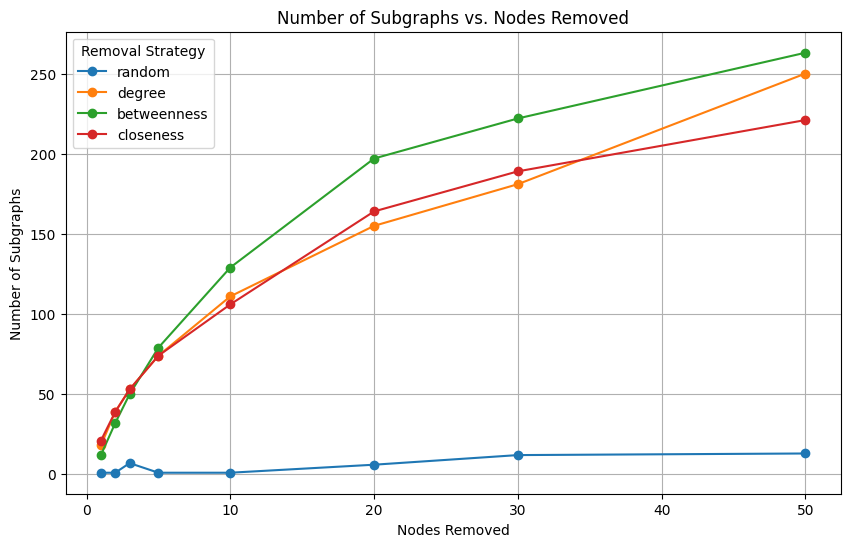

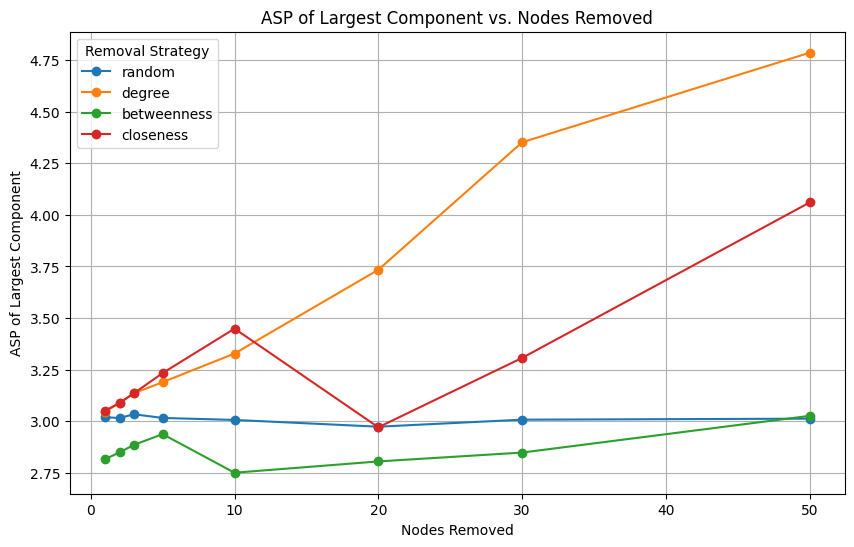

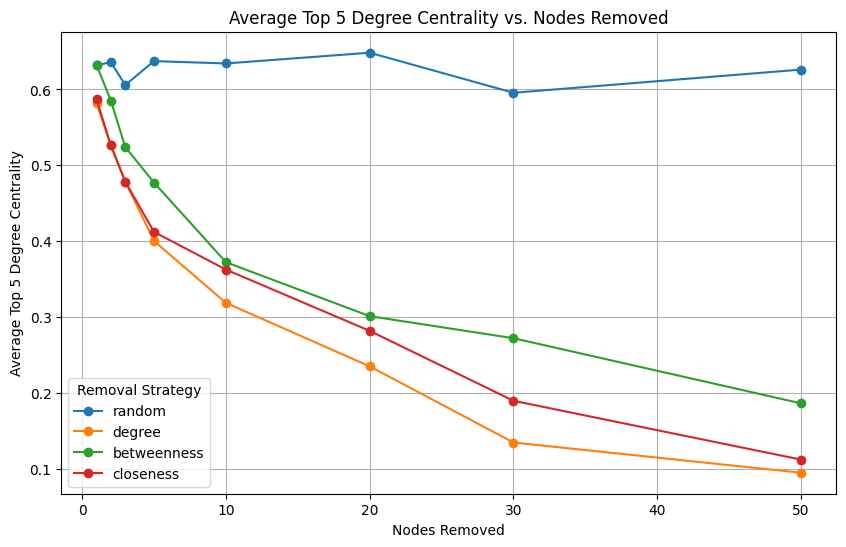

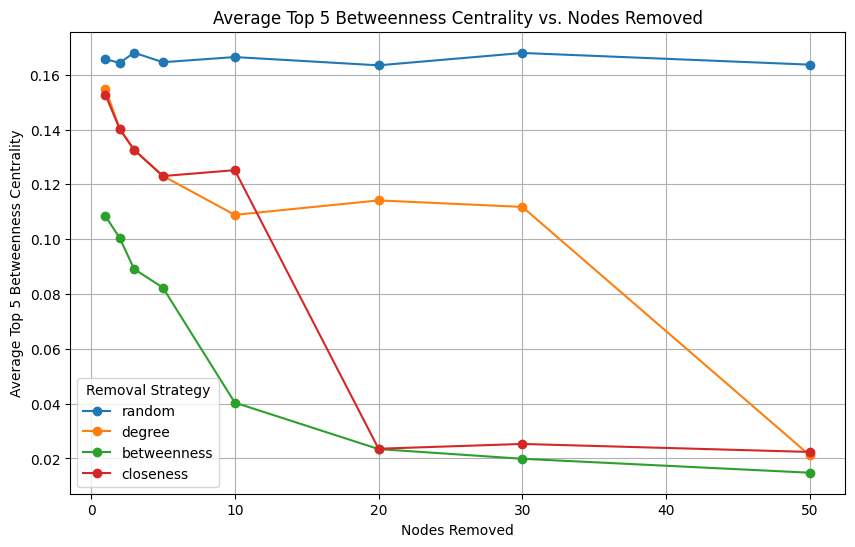

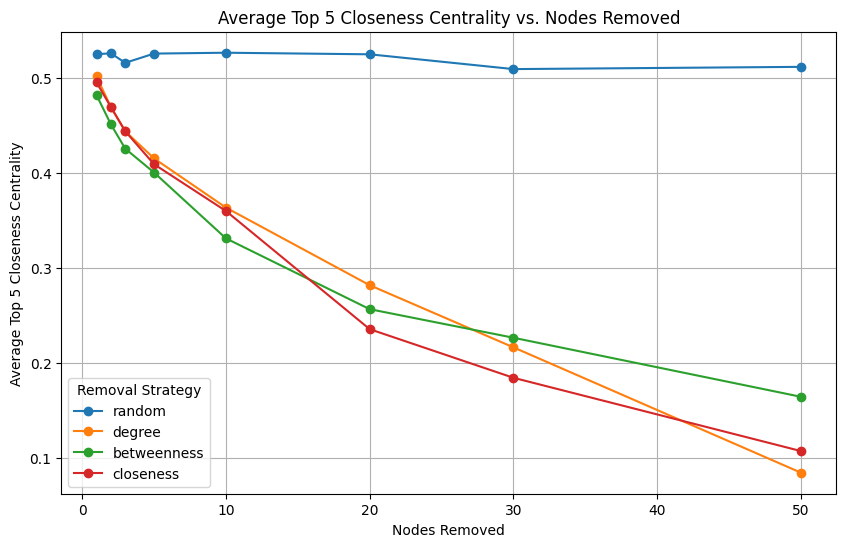

In [85]:
# Let's plot the results.

import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the file
file_path = "./flight_graph_filtered_analysis_results.csv"  # Adjust to match your file path
results_df = pd.read_csv(file_path)

# Extract unique strategies
strategies = results_df["Strategy"].unique()

# Plot 1: Number of Subgraphs vs. Nodes Removed
plt.figure(figsize=(10, 6))
for strategy in strategies:
    subset = results_df[results_df["Strategy"] == strategy]
    plt.plot(subset["Nodes Removed"], subset["Subgraphs"], label=strategy, marker='o')
plt.title("Number of Subgraphs vs. Nodes Removed")
plt.xlabel("Nodes Removed")
plt.ylabel("Number of Subgraphs")
plt.legend(title="Removal Strategy")
plt.grid(True)
plt.show()

# Plot 2: ASP of Largest Component vs. Nodes Removed
plt.figure(figsize=(10, 6))
for strategy in strategies:
    subset = results_df[results_df["Strategy"] == strategy]
    plt.plot(subset["Nodes Removed"], subset["ASP Largest Component"], label=strategy, marker='o')
plt.title("ASP of Largest Component vs. Nodes Removed")
plt.xlabel("Nodes Removed")
plt.ylabel("ASP of Largest Component")
plt.legend(title="Removal Strategy")
plt.grid(True)
plt.show()

# Plot 3: Centrality Measures vs. Nodes Removed
centrality_measures = [
    "Average Top 5 Degree Centrality",
    "Average Top 5 Betweenness Centrality",
    "Average Top 5 Closeness Centrality"
]

for measure in centrality_measures:
    plt.figure(figsize=(10, 6))
    for strategy in strategies:
        subset = results_df[results_df["Strategy"] == strategy]
        plt.plot(subset["Nodes Removed"], subset[measure], label=strategy, marker='o')
    plt.title(f"{measure} vs. Nodes Removed")
    plt.xlabel("Nodes Removed")
    plt.ylabel(measure)
    plt.legend(title="Removal Strategy")
    plt.grid(True)
    plt.show()
